# Lab 4: Predicting breast cancer with machine learning

In this lab we'll read up our training and test data to create a logistic regression model. We'll use different techniques to evaluate the model and use the model for prediction on a held-out dataset. 

#### Libraries used in this lab:
[pandas docs](https://pandas.pydata.org/pandas-docs/stable/)

[seaborn docs](https://seaborn.pydata.org/)

[matplotlib docs](https://matplotlib.org/contents.html)

[numpy docs](https://docs.scipy.org/doc/numpy-1.15.1/reference/index.html)

[sklearn docs](https://scikit-learn.org/stable/documentation.html)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [13]:
# read in data prepared from lab 2, split into two data sets
train = pd.read_csv("data_sets/lab_4_train.csv")
test = pd.read_csv("data_sets/lab_4_test.csv")

In [14]:
# create list of features, careful to remove diagnosis columns 
features = train.columns.tolist()
features.remove('diagnosis')
features.remove('diagnosis_code')

In [4]:
# Matrix representations of train and test sets
X_train = train.as_matrix(features)
X_train = np.concatenate([np.ones((X_train.shape[0],1)), X_train], axis=1)
Y_train = train.as_matrix(['diagnosis_code'])

X_test = test.as_matrix(features)
X_test = np.concatenate([np.ones((X_test.shape[0],1)), X_test], axis=1)
Y_test = test.as_matrix(['diagnosis_code'])

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(426, 11) (426, 1)
(143, 11) (143, 1)


## Create a Logistic Regression Model from Scratch

In [5]:
def predict(features, weights):
    '''
    Returns 1D array of probabilities
  that the class label == 1
  '''
    z = np.matmul(features, weights)
    sigmoid = np.divide(1, 1+np.exp(-z))
    return sigmoid


In [6]:
def loss_function(features, labels, weights):
    '''
    Using Mean Absolute Error

    Features:(100,3)
    Labels: (100,1)
    Weights:(3,1)
    Returns 1D matrix of predictions
    Cost = ( log(predictions) + (1-labels)*log(1-predictions) ) / len(labels)
    '''
    observations = labels.shape[0]

    predictions = predict(features, weights)

    #Take the error when label=1
    class1_cost = -labels*np.log(predictions)

    #Take the error when label=0
    class2_cost = (1-labels)*np.log(1-predictions)

    #Take the sum of both costs
    cost = class1_cost - class2_cost

    #Take the average cost
    cost = np.sum(cost, axis=0)/observations

    return cost

In [7]:
def update_weights(features, labels, weights, lr):
    '''
    Vectorized Gradient Descent

    Features:(200, 3)
    Labels: (200, 1)
    Weights:(3, 1)
    '''
    N = features.shape[0]

    #1 - Get Predictions
    predictions = predict(features, weights)

    #2 Transpose features from (200, 3) to (3, 200)
    # So we can multiply w the (200,1)  cost matrix.
    # Returns a (3,1) matrix holding 3 partial derivatives --
    # one for each feature -- representing the aggregate
    # slope of the cost function across all observations
    gradient = np.matmul(features.T,  predictions - labels)

    #3 Take the average cost derivative for each feature
    gradient /= N

    #4 - Multiply the gradient by our learning rate
    gradient *= lr

    #5 - Subtract from our weights to minimize cost
    weights -= gradient

    return weights

In [8]:
def train(features, labels, weights, lr, iters):
    cost_history = []
    x_axis = []
    
    
    fig, ax = plt.subplots(1,1)
    
    plt.show()
    

    for i in range(iters):
        weights = update_weights(features, labels, weights, lr)

        #Calculate error for auditing purposes
        cost = loss_function(features, labels, weights)
        cost_history.append(cost[0])
        x_axis.append(i)
        
        ax.clear()
        ax.set_xlabel('# iteration')
        ax.set_ylabel('Loss')
        ax.scatter(x_axis, cost_history)
        fig.canvas.draw()


    return weights, cost_history

## To Do
Vary the value of `lr` and explain ehat you observe

<IPython.core.display.Javascript object>


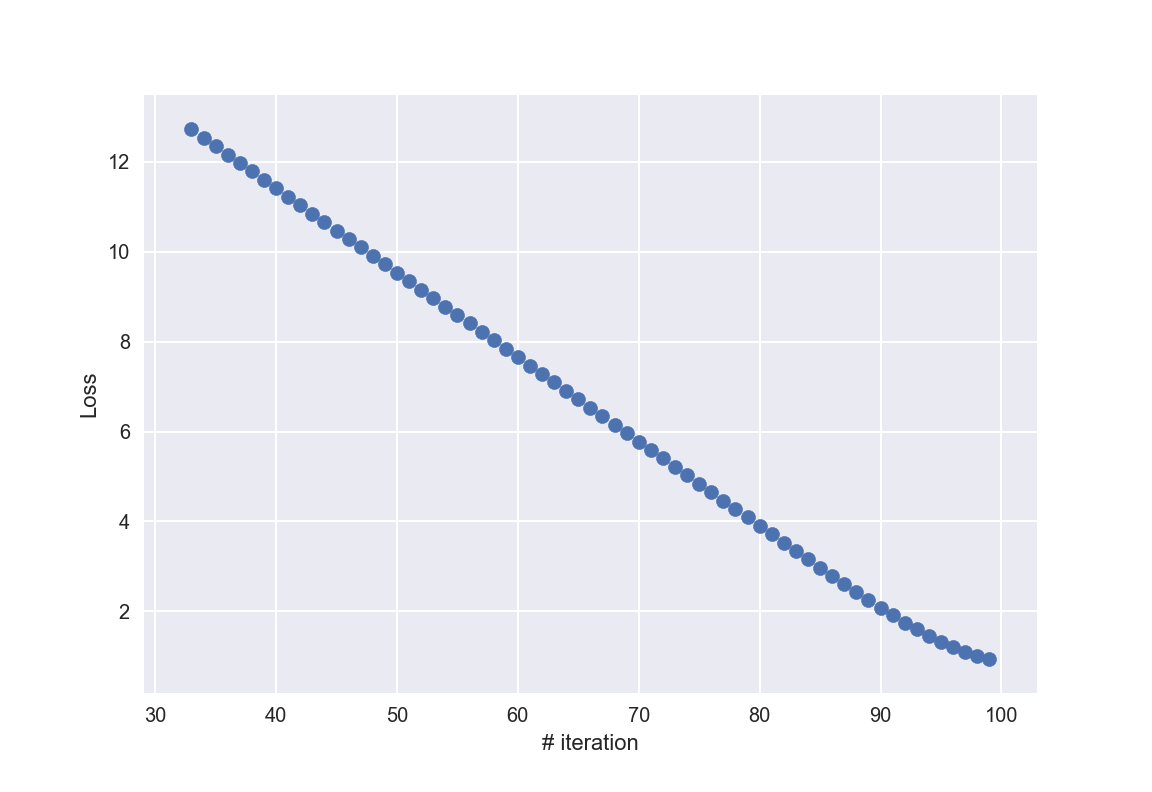

/Users/ozlemsenlik/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log
/Users/ozlemsenlik/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in multiply


In [9]:
% matplotlib notebook
results = train(X_train, Y_train, np.random.random_sample((11,1)), lr=0.001, iters=100)

## How training data size affects learning

In [10]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



<IPython.core.display.Javascript object>


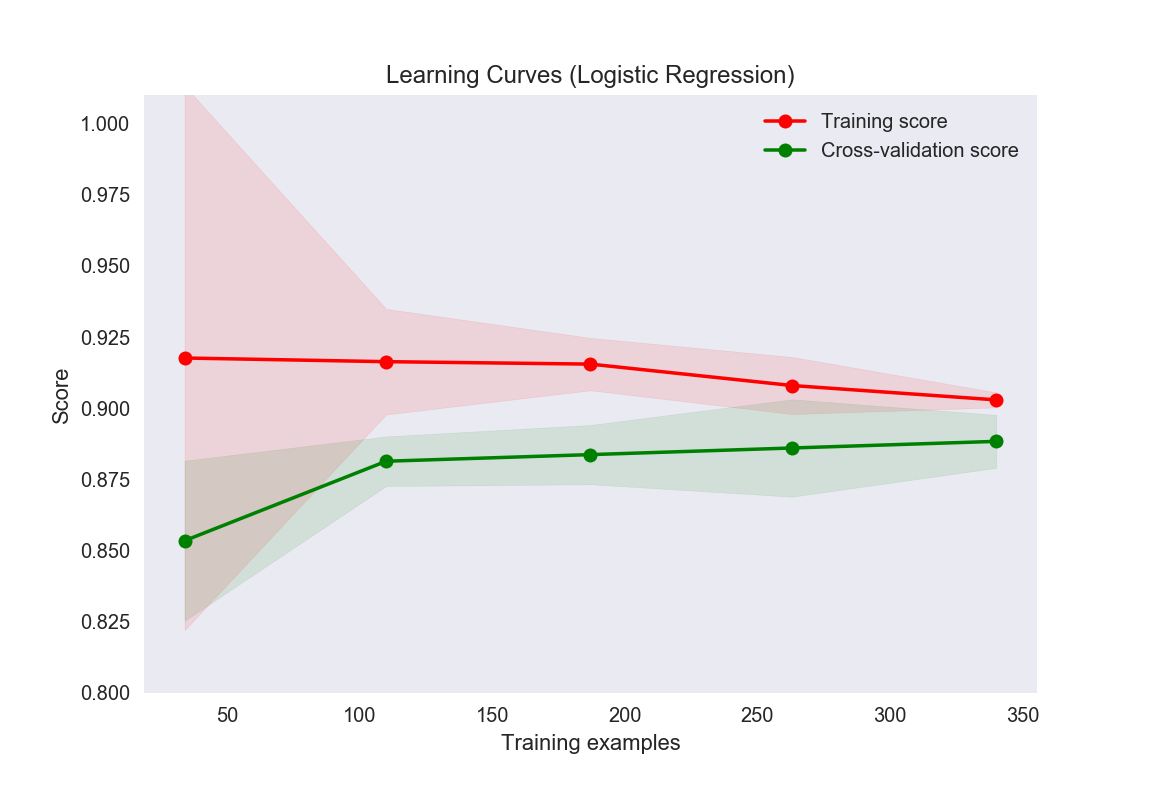

/Users/ozlemsenlik/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:811: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):
/Users/ozlemsenlik/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ozlemsenlik/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ozlemsenlik/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarni

In [11]:
title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = LogisticRegression(solver='lbfgs')
plot_learning_curve(estimator, title, X_train, Y_train, ylim=(0.8, 1.01), cv=cv, n_jobs=4)

plt.show()

## Logistic Regression Model from Existing Sklearn Library

In this section we use the [LogisticRegression classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) from scikit-learn library. We'll start with the default classifier settings which we will tune later on.

In [15]:
# fit model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(train[features], train['diagnosis_code'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

## Evaluate model: Error and Accuracy

Use held out test data to evaluate model for accuracy, error, and other metrics. Essentially we are comparing the predicted class against the true class for each example in the test set. 

In [16]:
# error and accuracy of model
from sklearn import metrics

def model_metrics(test, logreg, features):
    test_pred_prob = logreg.predict_proba(test[features])[:,1]
    test_pred = logreg.predict(test[features])
    test_true = test['diagnosis_code']
    print('log loss (error) on test set: {:.2f}'.format(metrics.log_loss(test_true, test_pred_prob)))
    print('Accuracy of model on test set: {:.2f}'.format(metrics.accuracy_score(test_true, test_pred)))
    print('Precision of model on test set: {:.2f}'.format(metrics.precision_score(test_true, test_pred)))
    print('Recall of model on test set: {:.2f}'.format(metrics.recall_score(test_true, test_pred)))

model_metrics(test, logreg, features)

log loss (error) on test set: 0.22
Accuracy of model on test set: 0.88
Precision of model on test set: 0.93
Recall of model on test set: 0.74


## To Do
Vary the thresold value and explain how classification metrics change.

In [17]:
def model_metrics_threshold(test, logreg, features, threshold):
    
    test_pred_prob = logreg.predict_proba(test[features])[:,1]
    test_pred = np.where(test_pred_prob>threshold, 1, 0)
    test_true = test['diagnosis_code']
    
    loss = metrics.log_loss(test_true, test_pred_prob)
    accuracy = metrics.accuracy_score(test_true, test_pred)
    precision = metrics.precision_score(test_true, test_pred)
    recall = metrics.recall_score(test_true, test_pred)
    
    print('log loss (error) on test set: {:.2f}'.format(loss))
    print('Accuracy of model on test set: {:.2f}'.format(accuracy))
    print('Precision of model on test set: {:.2f}'.format(precision))
    print('Recall of model on test set: {:.2f}'.format(recall))
    
    return loss, accuracy, precision, recall

metric = model_metrics_threshold(test, logreg, features, threshold=0.8)

log loss (error) on test set: 0.22
Accuracy of model on test set: 0.85
Precision of model on test set: 1.00
Recall of model on test set: 0.60


<IPython.core.display.Javascript object>


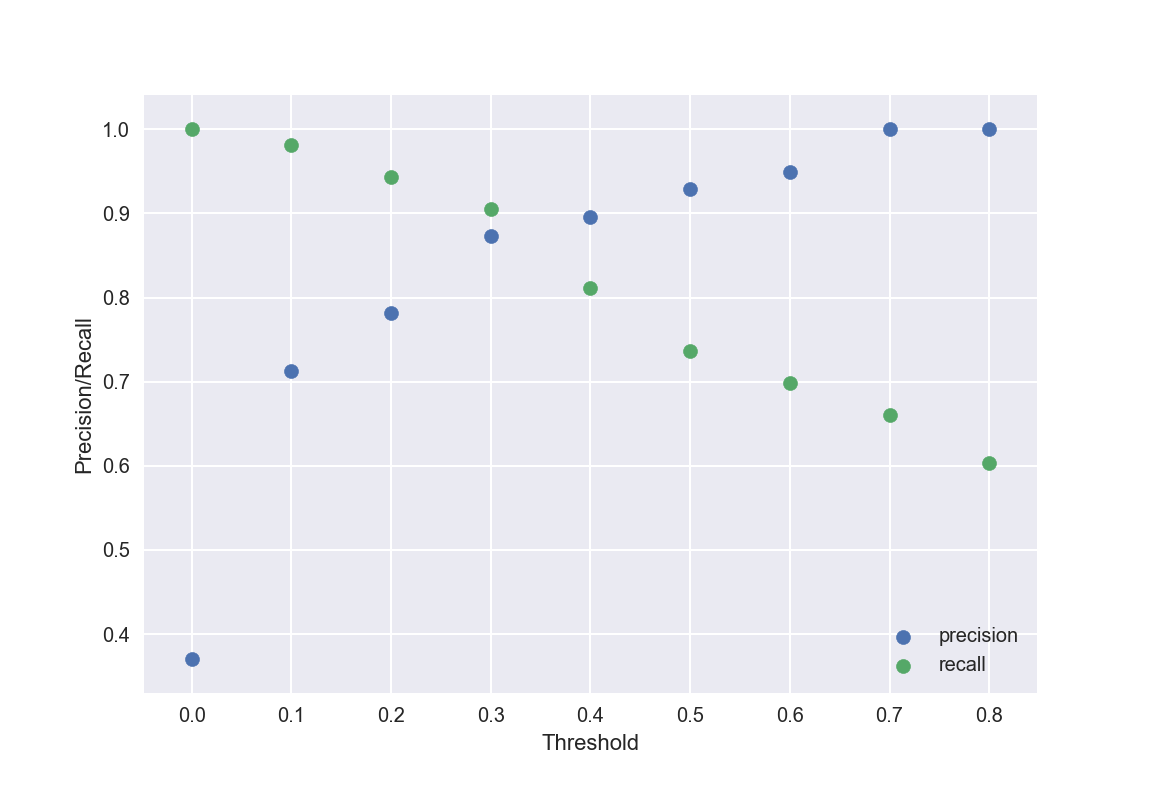

log loss (error) on test set: 0.22
Accuracy of model on test set: 0.37
Precision of model on test set: 0.37
Recall of model on test set: 1.00
log loss (error) on test set: 0.22
Accuracy of model on test set: 0.85
Precision of model on test set: 0.71
Recall of model on test set: 0.98
log loss (error) on test set: 0.22
Accuracy of model on test set: 0.88
Precision of model on test set: 0.78
Recall of model on test set: 0.94
log loss (error) on test set: 0.22
Accuracy of model on test set: 0.92
Precision of model on test set: 0.87
Recall of model on test set: 0.91
log loss (error) on test set: 0.22
Accuracy of model on test set: 0.90
Precision of model on test set: 0.90
Recall of model on test set: 0.81
log loss (error) on test set: 0.22
Accuracy of model on test set: 0.88
Precision of model on test set: 0.93
Recall of model on test set: 0.74
log loss (error) on test set: 0.22
Accuracy of model on test set: 0.87
Precision of model on test set: 0.95
Recall of model on test set: 0.70
log lo

In [23]:
loss = []
accuracy = []
precision = []
recall = []
threshold = []

fig, ax = plt.subplots(1,1)
plt.show()

for th in [0.1*i for i in range(9)]:
    ax.clear()
    l, a, p, r = model_metrics_threshold(test, logreg, features, th)
    
    threshold.append(th)
    loss.append(l)
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Precision/Recall')
    
    ax.scatter(threshold, precision,label='precision')
    ax.scatter(threshold, recall, label='recall')
    
    ax.legend()
    ax.grid(True)
    fig.canvas.draw()
    
    

The metrics above indicate that we have made a good start to creating a breast cancer predictve model. We'll attempt to improve these numbers futher in following sections

## Evaluate Model: AUC - ROC Curve

In the lecture we reviwed the AUC-ROC curve as a way to evaluate the model across threasholds. Below is the plot from the lecture.
<img src="images/auc_plot.png" style="height:500px">

In the following section we'll recreate the AUC - ROC plot on the test dataset.

AUC score of model on test set: 0.85


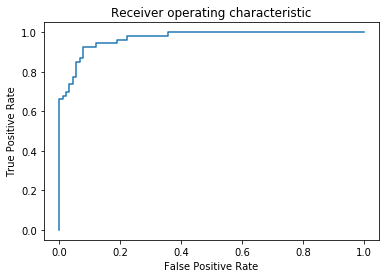

In [5]:
# create auc - roc curve
from sklearn import metrics

def create_roc_curve(test, logreg):
    test_pred = logreg.predict(test[features])
    test_true = test['diagnosis_code']
    test_predict_proba = logreg.predict_proba(test[features])[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_true=np.array(test_true), y_score=test_predict_proba, pos_label=1)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    print('AUC score of model on test set: {:.2f}'.format(metrics.roc_auc_score(test_true, test_pred)))

create_roc_curve(test, logreg)

## Evaluate Model: Visualize Sigmoid Curve

In the lecture we reviewed the sigmoid function as it relates to making binary classificaiton. Below is the plot from the lecture.
<img src="images/sigmoid.png" style="height:500px">

In the following section we'll plot the test set prediction probabilities against the `radius_mean` dimension. The s-like curve represents presentes a visualization of the sigmoid curve. 

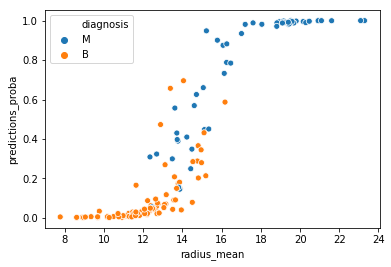

In [20]:
# create a scatter plot of prediction probabilities vs radius_mean
def create_sigmoid_plot(test, logreg, feature):
    test['predictions_proba'] = logreg.predict_proba(test[features])[:,1]
    sns.scatterplot(x=feature, y="predictions_proba", hue = "diagnosis", data=test)
    
create_sigmoid_plot(test, logreg, "radius_mean")

## Model Optimization: Hyperparameter tuning using Grid Search

Now that we have evaluated the first version of our Logistic Regression model let's see if we can improve it. We'll use scikit-learn [GridSearch method](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and apply different types of regularization over different values.

In [9]:
# range of regularization values
hyperparameters = {'C':np.logspace(0, 4, 100)}

logisticRegression = LogisticRegression(solver='lbfgs', max_iter=10000)
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(logisticRegression, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(train[features], train['diagnosis_code'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best C: 1555.6761439304723


## Exercise 1: Create and evaluate LR model for different levels of regularization

Using GridSearch above we were able to determine the best value of C to optimize our model. In this exercise please update the LR model with the new value for C, create new metrics for the model, and plot the AUC curve. To make it simple we are using the helper functions we created above: model_metrics() and create_roc_curve().

In [ ]:
# create and fit new model, please fill in missing arguments
logregV2 = LogisticRegression() 
logregV2.fit() 

In [ ]:
# evaluate model, fill in missing arguments
model_metrics()

In [ ]:
# create auc plot, fill in missing arguments
create_roc_curve()

How did your new model perform? What metrics improved or declined? Did the AUC curve value or curve change? Feel free to remake the sigmoid plot

## Prediction: Using the model to predict tumor type

In this section we'll use the first model to make predictions on the test data set. 

In [39]:
# create predictions for first row of test set
first_row_test = test.head(1)
print("test row TRUE value for tumor classfication is {}, target value {}".format(first_row_test['diagnosis'].values, first_row_test['diagnosis_code'].values))
print("test row prediction probability value {}".format(logreg.predict_proba(first_row_test[features])[:,1]))

test row TRUE value for tumor classfication is ['M'], target value [1]
test row prediction probability value [0.9915014]
